In [89]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from scipy import optimize

#Generate data
X = np.array(([3,5], [5,1], [10,2], [6,1.5]), dtype=float)
y = np.array(([75], [82], [93], [70]), dtype=float)

X = X/np.amax(X, axis=0)
y = y/100

In [90]:
#Training Data:
trainX = np.array(([3,5], [5,1], [10,2], [6,1.5]), dtype=float)
trainY = np.array(([75], [82], [93], [70]), dtype=float)

#Testing Data:
testX = np.array(([4, 5.5], [4.5,1], [9,2.5], [6, 2]), dtype=float)
testY = np.array(([70], [89], [85], [75]), dtype=float)

#Normalize:
trainX = trainX/np.amax(trainX, axis=0)
trainY = trainY/100 #Max test score is 100

#Normalize by max of training data:
testX = testX/np.amax(trainX, axis=0)
testY = testY/100 #Max test score is 100

In [91]:
#Neural network
class ANN(object):
    def __init__(self):        
        self.inLayerSize = 2
        self.outLayerSize = 1
        self.hLayerSize = 3
        
        self.w1 = np.random.randn(self.inLayerSize, self.hLayerSize)
        self.w2 = np.random.randn(self.hLayerSize, self.outLayerSize)
        
    def forward(self, X):
        self.z2 = np.dot(X, self.w1)
        #print self.z2.shape
        self.a2 = self.leaky(self.z2)
        self.z3 = np.dot(self.a2, self.w2)
        #print self.z3.shape
        yHat = self.leaky(self.z3) 
        return yHat
    
    def sigmoid(self, z):
        return 1/(1+np.exp(-z))
    
    def sigmoid_prime(self, z):
        return np.exp(-z)/((1+np.exp(-z))**2)
    
    def tanh(self, z):
        return np.tanh(z)
        #return 1/(1+np.exp(-z))
    
    def tanhPrime(self, z):
        return 1-np.square(np.tanh(z))
    
    def relu(self, z):
        for i in xrange(z.shape[0]):
            for j in xrange(z.shape[1]):
                if (z[i,j]<0):
                    z[i,j]=0
        return z
    
    def reluPrime(self, z):
        for i in xrange(z.shape[0]):
            for j in xrange(z.shape[1]):
                if (z[i,j]<0):
                    z[i,j]=0
                else:
                    z[i,j]=1
        return z
    
    def leaky(self, z):
        for i in xrange(z.shape[0]):
            for j in xrange(z.shape[1]):
                if (z[i,j]<0):
                    z[i,j]=z[i,j]*0.01
        return z
    
    def leakyPrime(self, z):
        for i in xrange(z.shape[0]):
            for j in xrange(z.shape[1]):
                if (z[i,j]<0):
                    z[i,j]=0.01
                else:
                    z[i,j]=1
        return z
    
    def costFunction(self, X, y):
        self.yHat = self.forward(X)
        J = 0.5*sum(np.square(y-self.yHat))
        return J
          
    def costFunctionPrime(self, X, y):
        self.yHat = self.forward(X)
        
        delta3 = np.multiply(-(y-self.yHat), self.leakyPrime(self.z3))
        dJdW2 = np.dot(self.a2.T, delta3)
        
        delta2 = np.dot(delta3, self.w2.T)*self.leakyPrime(self.z2)
        dJdW1 = np.dot(X.T, delta2)
        
        return dJdW1, dJdW2
    
    #Helper Functions for interacting with other classes:
    def getParams(self):
        #Get W1 and W2 unrolled into vector:
        params = np.concatenate((self.w1.ravel(), self.w2.ravel()))
        return params
    
    def setParams(self, params):
        #Set W1 and W2 using single paramater vector.
        W1_start = 0
        W1_end = self.hLayerSize * self.inLayerSize
        self.w1 = np.reshape(params[W1_start:W1_end], (self.inLayerSize , self.hLayerSize))
        W2_end = W1_end + self.hLayerSize*self.outLayerSize
        self.w2 = np.reshape(params[W1_end:W2_end], (self.hLayerSize, self.outLayerSize))
        
    def computeGradients(self, X, y):
        dJdW1, dJdW2 = self.costFunctionPrime(X, y)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))

In [92]:
#Train
class trainer(object):
    def __init__(self, N):
        self.N = N
        
    def callbackF(self, params):
        self.N.setParams(params)
        self.J.append(self.N.costFunction(self.X, self.y))   
        
    def costFunctionWrapper(self, params, X, y):
        self.N.setParams(params)
        cost = self.N.costFunction(X, y)
        grad = self.N.computeGradients(X,y)
        
        return cost, grad
        
    def train(self, X, y):
        self.X = X
        self.y = y

        self.J = []
        
        params0 = self.N.getParams()

        options = {'maxiter': 200, 'disp' : True}
        _res = optimize.minimize(self.costFunctionWrapper, params0, jac=True, method='BFGS', \
                                 args=(X, y), options=options, callback=self.callbackF)

        self.N.setParams(_res.x)
        self.optimizationResults = _res

In [93]:
#Check gradients
def computeNumericalGradient(N, X, y):
        paramsInitial = N.getParams()
        numgrad = np.zeros(paramsInitial.shape)
        perturb = np.zeros(paramsInitial.shape)
        e = 1e-4

        for p in range(len(paramsInitial)):
            #Set perturbation vector
            perturb[p] = e
            N.setParams(paramsInitial + perturb)
            loss2 = N.costFunction(X, y)
            
            N.setParams(paramsInitial - perturb)
            loss1 = N.costFunction(X, y)

            #Compute Numerical Gradient
            numgrad[p] = (loss2 - loss1) / (2*e)

            #Return the value we changed to zero:
            perturb[p] = 0
            
        #Return Params to original value:
        N.setParams(paramsInitial)

        return numgrad

Optimization terminated successfully.
         Current function value: 0.050709
         Iterations: 7
         Function evaluations: 9
         Gradient evaluations: 9


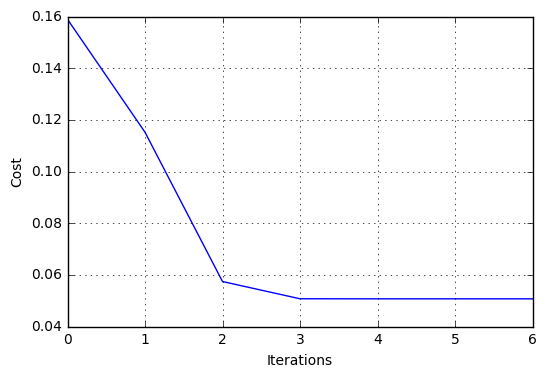

In [94]:
#Train network and print loss
NN = ANN()
T = trainer(NN)
T.train(X,y)

plt.plot(T.J)
plt.grid(1)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

In [95]:
print NN.forward(X)
print y

[[ 0.75147676]
 [ 0.54102305]
 [ 1.08204611]
 [ 0.67833196]]
[[ 0.75]
 [ 0.82]
 [ 0.93]
 [ 0.7 ]]


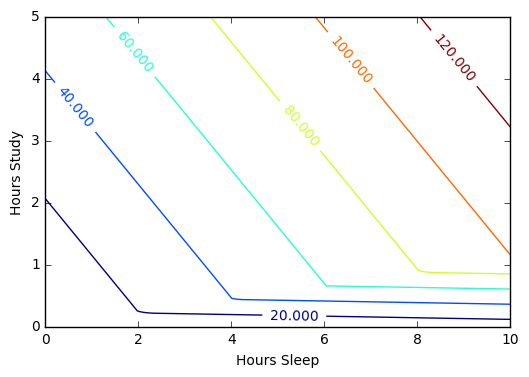

In [96]:
#Test network for various combinations of sleep/study:
hoursSleep = np.linspace(0, 10, 100)
hoursStudy = np.linspace(0, 5, 100)

#Normalize data (same way training data way normalized)
hoursSleepNorm = hoursSleep/10.
hoursStudyNorm = hoursStudy/5.

#Create 2-d versions of input for plotting
a, b  = np.meshgrid(hoursSleepNorm, hoursStudyNorm)

#Join into a single input matrix:
allInputs = np.zeros((a.size, 2))
allInputs[:, 0] = a.ravel()
allInputs[:, 1] = b.ravel()

allOutputs = NN.forward(allInputs)

#Contour Plot:
yy = np.dot(hoursStudy.reshape(100,1), np.ones((1,100)))
xx = np.dot(hoursSleep.reshape(100,1), np.ones((1,100))).T

CS = plt.contour(xx,yy,100*allOutputs.reshape(100, 100))
plt.clabel(CS, inline=1, fontsize=10)
plt.xlabel('Hours Sleep')
plt.ylabel('Hours Study')
plt.show()

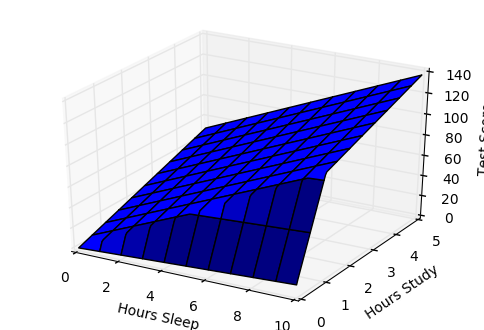

In [97]:
#3D plot:

##Uncomment to plot out-of-notebook (you'll be able to rotate)
#%matplotlib qt

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(xx, yy, 100*allOutputs.reshape(100, 100))

ax.set_xlabel('Hours Sleep')
ax.set_ylabel('Hours Study')
ax.set_zlabel('Test Score')

plt.show()